In [3]:
import Pkg
#Pkg.update("Flux")
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
  [587475ba] Flux v0.13.11


In [4]:
using Flux
using Zygote

using Plots

### <span style="color:orange">write a function and make a function for the gradient of the function</span>

In [5]:
f1(x) = 3x^2 - 2x + 10 # the function
df1(x) = gradient(f1, x)[1] # the gradient function df/dx = 6x - 2
d2f1(x) = gradient(df1, x)[1] # acceleration d²f/dx² = 6

d2f1 (generic function with 1 method)

In [6]:
grad1 = df1(10) # gradient at 1 point
grads2 = df1.([1,2,10]) #gradient at multiple points
accelerations = d2f1.([1,2,10])
println("grad1 = $(grad1), grads2 = $(grads2), accelerations = $(accelerations)")

grad1 = 58.0, grads2 = [4.0, 10.0, 58.0], accelerations = [6.0, 6.0, 6.0]


In [7]:
#for a 2D function
x = 1; y = 2
f2(x,y) = 2x^2 + 2y^2
display( gradient( f2, x, y ) )
display( gradient( f2, 10, 20 ) )
pp = [100,200]
gradient( f2, pp... ) #spread operator

(4.0, 8.0)

(40.0, 80.0)

(400.0, 800.0)

In [8]:
#automatic differentiation (AD) will differentiate a function
function f3(x, y)
    tmp1 = 2x^2
    tmp2 = 2y^2
    tmp3 = x / (y+1) #this statement is irrelevant to the final result returned, and is therefore ignored by AD automatically
    res = tmp1 + tmp2
    return res
end
display( gradient( f3, 10, 20 ) )

(40.0, 80.0)

### <span style="color:orange">We can find the gradient of a function with various computations inside and especially the well known MSE</span>

In [9]:
f_mse(x, y) = sum((x .- y).^2)

f_mse (generic function with 1 method)

In [10]:
xx = [2,1,0]
yy = [2,0,1]
grads = gradient(f_mse, xx, yy)
println("grads = $(grads)")

grads = ([0.0, 2.0, -2.0], [-0.0, -2.0, 2.0])


In [11]:
xx = [2,1,0]
yy = [2,0,1]
gs = gradient(Flux.params(xx, yy)) do
         f_mse(xx, yy)
        end

Grads(...)

In [12]:
fieldnames(typeof(gs))

(:grads, :params)

In [13]:
gs.grads

IdDict{Any, Any} with 4 entries:
  [2, 0, 1]  => [-0.0, -2.0, 2.0]
  :(Main.yy) => [-0.0, -2.0, 2.0]
  [2, 1, 0]  => [0.0, 2.0, -2.0]
  :(Main.xx) => [0.0, 2.0, -2.0]

In [14]:
gs.params

Params([[2, 1, 0], [2, 0, 1]])

In [15]:
gs[xx]

3-element Vector{Float64}:
  0.0
  2.0
 -2.0

In [16]:
gs[yy]

3-element Vector{Float64}:
 -0.0
 -2.0
  2.0

### <span style="color:orange">regression</span>

In [17]:
x, y = rand(5), rand(2) #transformation 5 features (dims) -> 2 featuers (dims)
W = rand(2, 5)
b = rand(2)
m1(x) = W*x .+ b
function loss1(x, y)
    y_hat = m1(x)
    sum((y .- y_hat).^2)
end
loss1(x,y)

2.1601175661582848

In [18]:
gs = gradient(() -> loss1(x, y), Flux.params(W, b))

Grads(...)

In [19]:
gs[W]

2×5 Matrix{Float64}:
 0.158154  0.333273  0.907344  0.142404  1.15458
 0.227401  0.479195  1.30462   0.204755  1.66011

In [20]:
gs[b]

2-element Vector{Float64}:
 1.6783550794765152
 2.4132124837710665

In [21]:
W_grad = gs[W]

2×5 Matrix{Float64}:
 0.158154  0.333273  0.907344  0.142404  1.15458
 0.227401  0.479195  1.30462   0.204755  1.66011

### <span style="color:orange">Update parameter **W** (the transformation matrix) by a step</span>

In [22]:
W = W .- (0.1 .* W_grad )

2×5 Matrix{Float64}:
 0.307893  0.692127  0.343702  0.347793  -0.112495
 0.50933   0.208322  0.353107  0.524997   0.434809

In [23]:
loss1(x,y)

1.508964147978624

### <span style="color:orange">And another step in that direction</span>

In [24]:
W = W .- (0.1 .* W_grad )
loss1(x,y)

0.9742957240778742

### <span style="color:orange">And another step</span>

In [25]:
W = W .- (0.1 .* W_grad )
loss1(x,y)

0.556112294456036

### <span style="color:orange">And another step</span>

In [26]:
W = W .- (0.1 .* W_grad )
loss1(x,y) #over stepped?..

0.2544138591131091

### <span style="color:orange">many steps, but too many?..</span>

In [27]:
for ii in 1:10
    W = W .- (0.1 .* W_grad )
    display( loss1(x,y) ) #over stepped?..
end

0.06920041804909334

0.00047197126398877427

0.04822851875779545

0.21247006053051332

0.49319659658214254

0.8904081269126828

1.4041046515221347

2.034286170410497

2.7809526835777714

3.644104191023956

### <span style="color:orange">Layers (sequential transformations)</span>

In [28]:
W1 = rand(3, 5) #5 to 3 transformation
b1 = rand(3)
layer1(x) = W1 * x .+ b1

W2 = rand(2, 3) #3 to 2 transformation
b2 = rand(2)
layer2(x) = W2 * x .+ b2

m2(x) = layer2(sigmoid.(layer1(x))) |> gpu #move model to GPU (if available, or else it stays on the CPU by default)

x_rnd_input = rand(5)
out1 = m2( x_rnd_input ) #transforming 5 to 3, then 3 to 2 dims with an activation layer of sigmoid 
display( out1 )
out2 = m2( x_rnd_input |> gpu ) |> cpu #put the data to the GPU (if available) where the model is, and the final output back to the CPU
display( out2 )

┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /home/resort/.julia/packages/Flux/v79Am/src/functor.jl:218


2-element Vector{Float64}:
 2.0508161401557192
 1.8751867779355953

2-element Vector{Float64}:
 2.0508161401557192
 1.8751867779355953

In [29]:
x, y = rand(5), rand(2)
function loss2(x, y)
    y_hat = m2(x)
    sum((y .- y_hat).^2)
end

loss2 (generic function with 1 method)

In [30]:
gs = gradient(() -> loss2(x, y), Flux.params(W1, b1, W2, b2))

Grads(...)

In [31]:
gs[W1]

3×5 Matrix{Float64}:
 0.0369496  0.0717265  0.0439852  0.0998147  0.0186622
 0.0677995  0.131612   0.0807092  0.183152   0.0342436
 0.278922   0.541444   0.332032   0.753474   0.140876

In [32]:
gs[W2]

2×3 Matrix{Float64}:
 3.5948   3.54476  2.94392
 2.17684  2.14654  1.7827

In [33]:
loss2(x, y) #model loss

5.071084257708857

In [34]:
W1_grad = gs[W1]
W2_grad = gs[W2]

2×3 Matrix{Float64}:
 3.5948   3.54476  2.94392
 2.17684  2.14654  1.7827

In [35]:
W1 = W1 .- (0.1 .* W1_grad ) 
W2 = W2 .- (0.1 .* W2_grad ) 

2×3 Matrix{Float64}:
 -0.214554  0.0492904  0.600857
  0.358399  0.389217   0.475288

In [36]:
loss2(x, y) #model loss

1.4354620101631999

In [37]:
W1 = W1 .- ( 0.1 .* W1_grad )
W2 = W2 .- ( 0.1 .* W2_grad )

2×3 Matrix{Float64}:
 -0.574034  -0.305186  0.306465
  0.140714   0.174562  0.297018

In [38]:
loss2(x, y)

0.02617102450911897

### <span style="color:orange">Let's make a **Chain** of transformations rather than separate transformations</span>

In [39]:
W1 = rand(3, 5) |> gpu #5 to 3 transformation
b1 = rand(3) |> gpu
W2 = rand(2, 3) |> gpu #3 to 2 transformation
b2 = rand(2) |> gpu

m3 = Chain( x -> W1 * x .+ b1 , x -> sigmoid.(x) , x -> W2 * x .+ b2 ) |> gpu  #processes each transformation in a 'chained' sequence (manual)


Chain(#7, #8, #9)

In [44]:
x, y = rand(5), rand(2)
function loss3(x, y)
    y_hat = m3(x)
    sum((y .- y_hat).^2)
end

loss3 (generic function with 1 method)

In [45]:
gs = gradient(() -> loss3(x, y), Flux.params(W1, b1, W2, b2))

Grads(...)

In [46]:
loss3(x, y)

1.3271721095814484

In [47]:
W1_grad = gs[W1]
W2_grad = gs[W2]
W1 = W1 .- (0.1 .* W1_grad )
W2 = W2 .- (0.1 .* W2_grad )
loss3(x, y)

0.3725305388806626

In [48]:
W1 = W1 .- (0.1 .* W1_grad ) 
W2 = W2 .- (0.1 .* W2_grad ) 
loss3(x, y)

0.004973771152994737

### <span style="color:orange">Function composition</span>

- https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping
- https://math.libretexts.org/Courses/Western_Connecticut_State_University/Draft_Custom_Version_MAT_131_College_Algebra/03%3A_Functions/3.04%3A_Composition_of_Functions
- '\circ' is the operator symbol or use '|>' as a pipe

### <span style="color:orange">Use the **Dense Layer** function to make the transformations</span>

- the weights for the transformations are initialized automatically

In [49]:
#notice that the equivalence is produced from different orders of pipe VS compositions
println( 1:10 |> sum |> sqrt ) 
println( (sqrt ∘ sum)(1:10) )

println( 1:10 |> sum |> sqrt |> log ) 
println( (log ∘ sqrt ∘ sum)(1:10) )

7.416198487095663
7.416198487095663
2.0036665926162356
2.0036665926162356


In [50]:
#let's use Flux components rather than the lambdas and closures
m4 = Dense(3 => 2) ∘ Dense(5 => 3,sigmoid) #equivalent to m4 = Chain(Dense(5,3,sigmoid),Dense(3,2))

Dense(3 => 2) ∘ Dense(5 => 3, σ)

In [51]:
# the weights and matrices are no longer supplied 'manually' but are part of the Dense layer object
x = rand(5)
y = [1,2] #rand(2)
function loss4(y_hat, y)
    sum((y .- y_hat).^2)
end
loss4( m4(x), y )

13.650069707947074

In [52]:
opt = Flux.setup(Flux.Adam(0.1), m4); #this way stores momentum when used with Adam

In [53]:
#use Flux's inbuilt api to get the gradients for the composite function
loss, grads = Flux.withgradient(m4) do model
    # Evaluate model and loss inside gradient context:
    y_hat = model(x)
    loss4(y_hat, y) #Flux.mse(y_hat,y) 
end
println("loss = $(loss)")

loss = 13.650069707947074


In [54]:
# single application of the gradients to the parameters of the model based on the dynamic of the optimizer
Flux.update!(opt, m4, grads[1])

((outer = (weight = Leaf(Adam{Float64}(0.1, (0.9, 0.999), 1.0e-8), (Float32[-0.126272 -0.283728 -0.1393; -0.204107 -0.458619 -0.225164], Float32[0.00159447 0.00805018 0.00194044; 0.00416597 0.0210331 0.0050699], (0.81, 0.998001))), bias = Leaf(Adam{Float64}(0.1, (0.9, 0.999), 1.0e-8), (Float32[-0.388757, -0.628387], Float32[0.0151132, 0.0394871], (0.81, 0.998001))), σ = ()), inner = (weight = Leaf(Adam{Float64}(0.1, (0.9, 0.999), 1.0e-8), (Float32[0.0380401 0.0161815 … 0.0148784 0.0264613; 0.174592 0.0742678 … 0.068287 0.121449; 0.199108 0.0846965 … 0.0778758 0.138503], Float32[0.000144705 2.6184f-5 … 2.21366f-5 7.00201f-5; 0.00304822 0.00055157 … 0.000466311 0.00147498; 0.00396439 0.000717349 … 0.000606465 0.0019183], (0.81, 0.998001))), bias = Leaf(Adam{Float64}(0.1, (0.9, 0.999), 1.0e-8), (Float32[0.0407295, 0.186935, 0.213185], Float32[0.000165889, 0.00349448, 0.00454477], (0.81, 0.998001))), σ = ())), Dense(3 => 2) ∘ Dense(5 => 3, σ))

In [55]:
#get the new loss after a step of optimization
y_hat = m4(x)
loss4(y_hat, y) #Flux.mse(y_hat,y) 

10.03942218485523

In [56]:
#another step
Flux.update!(opt, m4, grads[1])
y_hat = m4(x)
Flux.mse(y_hat,y)

3.6882896908355844

In [57]:
#improvements and then errors get worse using the >same graident (direction of optimization)< without getting new gardients
for ii in 1:20
    Flux.update!(opt, m4, grads[1])
    y_hat = round.(m4(x),digits=4)
    loss_tmp = round.(Flux.mse(y_hat,y),digits=4)
    if(ii%5 < 3) println("loss_tmp = $(loss_tmp), prediction = $(y_hat)") end
end

loss_tmp = 2.7267, prediction = [0.0207, -0.12]
loss_tmp = 2.0413, prediction = [0.2416, 0.1272]
loss_tmp = 0.9499, prediction = [0.7035, 0.6539]
loss_tmp = 0.7578, prediction = [0.818, 0.7824]
loss_tmp = 0.6098, prediction = [0.9234, 0.8983]
loss_tmp = 0.3359, prediction = [1.2184, 1.21]
loss_tmp = 0.2881, prediction = [1.315, 1.3093]
loss_tmp = 0.2601, prediction = [1.412, 1.408]
loss_tmp = 0.2926, prediction = [1.7054, 1.7041]
loss_tmp = 0.3426, prediction = [1.804, 1.8032]
loss_tmp = 0.4125, prediction = [1.903, 1.9024]
loss_tmp = 0.7416, prediction = [2.2012, 2.201]


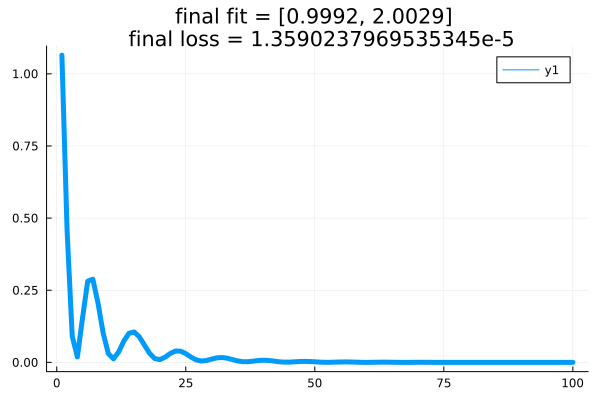

In [58]:
m4b = Dense(3 => 2) ∘ Dense(5 => 3,sigmoid) |> gpu
x = rand(5) |> gpu
y = [1,2] |> gpu
opt = Flux.setup(Flux.Adam(0.1), m4b)
losses = []
for ii in 1:100
    loss, grads = Flux.withgradient(m4b) do model
        y_hat = model(x)
        Flux.mse(y_hat,y) 
    end
    push!(losses,loss) #don't put this in the above block where the gradient is computed
    Flux.update!(opt, m4b, grads[1])
end
plot(losses, linewidth=5, title="final fit = $(round.( m4b(x) ,digits=4)) \n final loss = $(losses[end])")

### <span style="color:orange">Use the **Chain** to creat the sequence of transformations</span>

- notice how the order from right to left changes with 

In [59]:
m5 = Chain(  Dense(5 => 3, sigmoid) , Dense(3 => 2)  )

Chain(
  Dense(5 => 3, σ),                     # 18 parameters
  Dense(3 => 2),                        # 8 parameters
)                   # Total: 4 arrays, 26 parameters, 360 bytes.

In [60]:
# the weights and matrices are no longer supplied 'manually' but are part of the Dense layer object
x = [1,0,1,0,1]
y = [3,-3] #rand(2)

2-element Vector{Int64}:
  3
 -3

In [61]:
opt = Flux.setup(Flux.Descent(0.01), m5)

(layers = ((weight = Leaf(Descent{Float64}(0.01), nothing), bias = Leaf(Descent{Float64}(0.01), nothing), σ = ()), (weight = Leaf(Descent{Float64}(0.01), nothing), bias = Leaf(Descent{Float64}(0.01), nothing), σ = ())),)

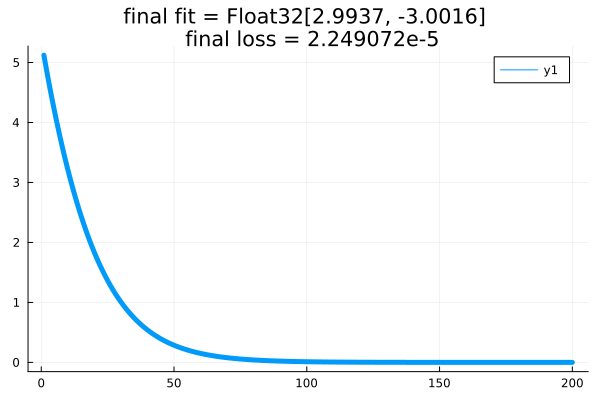

In [62]:
epochs = 200
losses = []
for ii in 1:epochs
    loss, grads = Flux.withgradient(m5) do model
        y_hat = model(x)
        Flux.mse(y_hat,y) 
    end
    push!(losses,loss) #don't put this in the above block where the gradient is computed
    Flux.update!(opt, m5, grads[1])
end
plot(losses, linewidth=5, title="final fit = $(round.( m5(x) ,digits=4)) \n final loss = $(losses[end])")

### <span style="color:orange">Using a different optimizer **Adam**</span>

- Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).

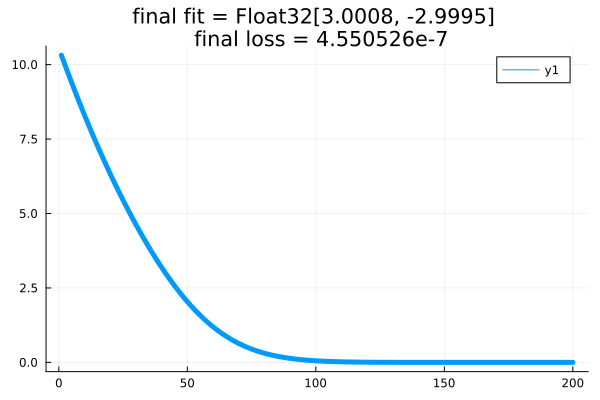

In [63]:
m5 = Chain(  Dense(5 => 3, sigmoid) , Dense(3 => 2)  )
opt = Flux.setup(Flux.Adam(0.01), m5)
epochs = 200
losses = []
for ii in 1:epochs
    loss, grads = Flux.withgradient(m5) do model
        y_hat = model(x)
        Flux.mse(y_hat,y) 
    end
    push!(losses,loss) #don't put this in the above block where the gradient is computed
    Flux.update!(opt, m5, grads[1])
end
plot(losses, linewidth=5, title="final fit = $(round.( m5(x) ,digits=4)) \n final loss = $(losses[end])")

### <span style="color:orange">Defining the Chain using another Chain as a component</span>

In [64]:
part1 = Chain( Dense(5 => 3, sigmoid), Dense(3 => 3) )
part2 = Dense(3 => 2)
m5b = Chain(  part1 , part2  )

Chain(
  Chain(
    Dense(5 => 3, σ),                   # 18 parameters
    Dense(3 => 3),                      # 12 parameters
  ),
  Dense(3 => 2),                        # 8 parameters
)                   # Total: 6 arrays, 38 parameters, 600 bytes.

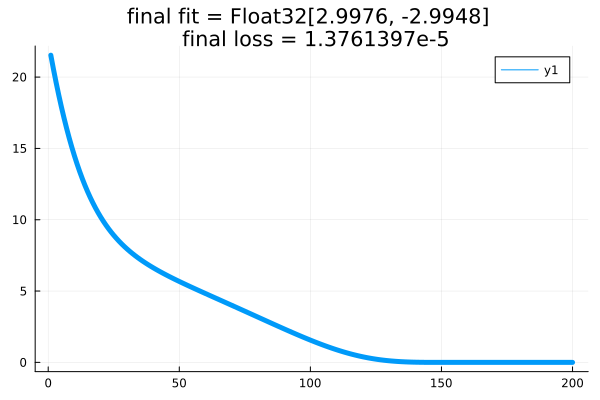

In [65]:
opt = Flux.setup(Flux.Adam(0.01), m5b)
epochs = 200
losses = []
for ii in 1:epochs
    loss, grads = Flux.withgradient(m5b) do model
        y_hat = model(x)
        Flux.mse(y_hat,y) 
    end
    push!(losses,loss) #don't put this in the above block where the gradient is computed
    Flux.update!(opt, m5b, grads[1])
end
plot(losses, linewidth=5, title="final fit = $(round.( m5b(x) ,digits=4)) \n final loss = $(losses[end])")

### <span style="color:orange">The Single Neuron Model</span>
**supervised learning**

Labeled data, D = $\{(x_1,y_2),(x_2,y_2),\ldots,(x_n,y_n)\}$

Each data point can be considered to be a 'signal' (common in the journal publications to see the data points referred to as) x_i

$x_i + 1 \rightarrow (w_1,b) \rightarrow z = w_1 * x_i + b \rightarrow a = \phi(z) $

Here $z$ can be considered to be a 'pre-activation' and $a$ a post-activation, that exists within the neuron. That is within the single neuron there are 2 steps, the production of $z$ that is a linear 'projection'/'transformation' and the $a$ is the 'activation' that is typically non-linear (eg. sigmoid or rectified linear units 'relu')

There is a 'cost' function for the neuron, in a manner similar to that of the common statistical fits

$C(w,b) = \sum_{i=1}^N dist(y,\hat{y}_i)$

The cost function gives us a 'landscape' (hyperdimensional surface of $y$ and $\hat{y}$ similarity for the parameters of the model) to minimize the cost (degree of fit). Our goal is to find $W$ and $b$ which minimizes $C$. The cost function can from a variety of forms based upon the 'dist' function where in regression cases it is often mean squared error, and in categorical predictions cross entropy

### <span style="color:orange">Dense Layer</span>

The **Dense** layer used corresponds to the $\phi$ function above that produces the non-linear *activation* operation upon the transformed values in *z*

In [66]:
rdata = rand( 5, 64)

5×64 Matrix{Float64}:
 0.498113   0.355374    0.192114   0.464119  …  0.494731  0.0972886  0.990337
 0.0161848  0.00669118  0.283127   0.325446     0.291916  0.843604   0.454829
 0.140428   0.178134    0.888992   0.831779     0.549308  0.867718   0.731593
 0.245069   0.105228    0.206985   0.268771     0.182588  0.666059   0.97976
 0.303348   0.80106     0.0565726  0.853713     0.403424  0.253784   0.814063

In [67]:
d1 = Dense(5 => 2)
d2 = Dense(5 => 2, identity)
d3 = Dense(5 => 2, sigmoid)
d4 = Dense(5 => 2, tanh)

Dense(5 => 2, tanh)  # 12 parameters

In [68]:
d1(rdata)

2×64 Matrix{Float64}:
 -0.169381   -0.0356449  -0.00148415  …  -0.181294  -0.628275  -0.709601
 -0.0440524   0.208447   -0.850451       -0.435322  -1.46035   -0.895633

In [69]:
d2(rdata)

2×64 Matrix{Float64}:
 0.395557  0.235133  0.327072  0.539293  …  0.54147   0.821033  1.21285
 0.051302  0.269264  0.66706   0.736501     0.337699  0.605833  0.489518

In [70]:
d3(rdata)

2×64 Matrix{Float64}:
 0.566826  0.661177  0.408097  0.583251  …  0.499039  0.414239  0.626475
 0.435638  0.410761  0.588297  0.469335     0.468629  0.531859  0.388548

In [71]:
d4(rdata)

2×64 Matrix{Float64}:
 0.23009     0.404187   0.683446  …   0.674115   0.667508   0.634967
 0.0570617  -0.185732  -0.63821      -0.44965   -0.802105  -0.427264

In [72]:
d1( [0,1,10,100,1000] )

2-element Vector{Float32}:
 -16.444477
 353.72607

In [73]:
d3( [0,1,10,100,1000] )

2-element Vector{Float32}:
 1.0
 0.0

In [74]:
d4( [0,1,10,100,1000] )

2-element Vector{Float32}:
  1.0
 -1.0

### <span style="color:orange">There are other layer types likes the **Conv** layer type (CNNs)</span>

- They follow the type: Width-Height-Channel-NumberOfImages (WHCN)
- for 32 color images of 50x50 pixels that has a WHCN size of (50,50,3,32)
- You can do CNN convolutional layers on 1D data too (sound / audio data) where there are 2 channels in stereo, and for let's say 72 samples(recordings) the size is (72, 2, 1)
- 3D Conv layers would add an extra dimension so if the 3D images (eg medical) are 50x50x50, that is (50,50,50,3,32)

- **Stride**: the CNN filters move/jump/reposition themselves how many pixels eeach time (the filter 'patch' is shifted how many pixels each time)
- **Padding**: due to edge boundaries the filters cannot produce the same image number of pixels (shrinks) are each application so many layers would shrink the image by alot. Also pixels on the boudnary/edge of the image get used in fewer filter operations than those in the middle areas. So padding adds 0 pixels on the outer perimeter. to maintain the same image size use

$paddingSize = \frac{f-1}{2}$

since

$n + 2p - f + 1 = n$

- **Dilation** widens the kernel by skipping pixels so the filter covers a wider area

functional usage: $Conv(filter, in => out, \sigma = identity; stride = 1, pad = 0, dilation = 1, groups = 1, [bias, init])$

In [75]:
conv_layer1 = Conv((5,5), 3 => 7, relu)

Conv((5, 5), 3 => 7, relu)  # 532 parameters

In [76]:
image1 = rand(Float32, 50, 50, 3, 1) #3 channel image (color)

50×50×3×1 Array{Float32, 4}:
[:, :, 1, 1] =
 0.11729   0.638274    0.387497   …  0.38861     0.672906   0.612145
 0.31469   0.937711    0.0117772     0.342187    0.655649   0.605933
 0.481106  0.259454    0.813764      0.594679    0.391018   0.278283
 0.111096  0.421718    0.723585      0.769826    0.958072   0.626982
 0.364742  0.158636    0.0414262     0.202705    0.0766302  0.207687
 0.841801  0.211367    0.0113934  …  0.898171    0.547446   0.852512
 0.762146  0.0142676   0.557325      0.120092    0.348723   0.607283
 0.882787  0.330048    0.773886      0.735143    0.0956654  0.314466
 0.216877  0.469716    0.943748      0.48482     0.290198   0.337734
 0.101963  0.827281    0.0227942     0.290876    0.247262   0.8046
 0.459923  0.490272    0.822114   …  0.246255    0.412026   0.942416
 0.923182  0.495092    0.251625      0.747043    0.272601   0.800183
 0.597375  0.116043    0.280647      0.251194    0.611419   0.742643
 ⋮                                ⋱                         


### <span style="color:orange">Pass the image into the Conv layer but notice the size change of the image and the channel number increase</span>

In [77]:
size( conv_layer1(image1) )

(46, 46, 7, 1)

### <span style="color:orange">Add padding to this new Conv layer to see the size be preserved</span>

In [78]:
conv_layer2 = Conv((5,5), 3 => 7, relu, pad=2)

Conv((5, 5), 3 => 7, relu, pad=2)  # 532 parameters

In [79]:
size( conv_layer2(image1) )

(50, 50, 7, 1)

### <span style="color:orange">More will be said about different layers later on</span>

- BatchNorm
- Dropout

and more

### <span style="color:orange">Activation Functions</span>

- Between 'neurons'/'perceptrons'/'transformations'/'layers' we take the linear transformation, and produce an **activation** that is a non-linear tranformation. This is the linear tranformation value produced 'z' that is then tranformed with the non-linear activation function $\phi$ to produce the output $a$, from operations: $ z = w_1 * x_i + b \rightarrow a = \phi(z) $
- The activation function produces $ a = \phi(z) $
- If your 'layer' has only one dimension output $R^N \rightarrow R^1$ (with X input having $N$ dimension and only 1 neuron in that layer) then there is 1 activation function applied, but if there are more neurons in the layer, then multiple activation functions are applied, 1 for each neuron in the layer $R^N \rightarrow R^3$ 3 activation function applications
- These $\phi$ functions can be varied and are an area of research themselves. Although apparently simple in their operation, the consequences of the choices of these functions can change both the performance accuracies and even the performance run time
- Softmax is not *strictly* considered to be an *activation* function. We use softmax at the end output to get a probability distribution over a vector of outputs to produce another vector of outputs of the same length that then is a normalized distribution for categorical probability predictions.
- Many functions exist but we will cover a few major ones only, and you can even research your own functions yourself as novel functions and explore the pros and cons for each one

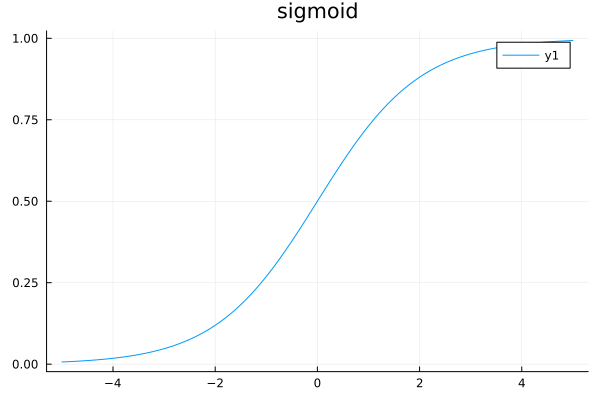

In [80]:
# 'σ' symbol or 'sigma' can be used for the sigmoid, σ(x) = 1 / (1 + exp(-x))
plot(-5:0.1:5,sigmoid,title="sigmoid")

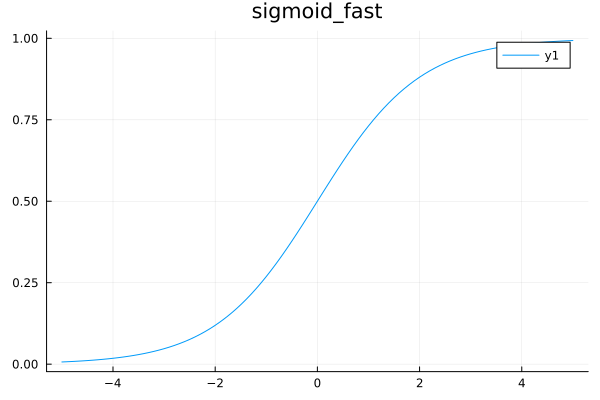

In [81]:
# sigmoid_fast is a faster less accurate version of the sigmoid
plot(-5:0.1:5,sigmoid_fast,title="sigmoid_fast")

### <span style="color:orange">Let's compare the running time of the normal sigmoid and the faster version using the convenient Julia macro @time</span>

In [82]:
rr = rand(10^6);
@time sigmoid.( rr );

  0.007295 seconds (4 allocations: 7.629 MiB)


In [83]:
@time sigmoid_fast.( rr );

  0.024490 seconds (834 allocations: 7.667 MiB, 66.69% compilation time)


In [84]:
# relu(x) = max(0, x) simple and powerful, very fast too
@time relu.( rr );

  0.041233 seconds (126.71 k allocations: 14.230 MiB, 93.45% compilation time)


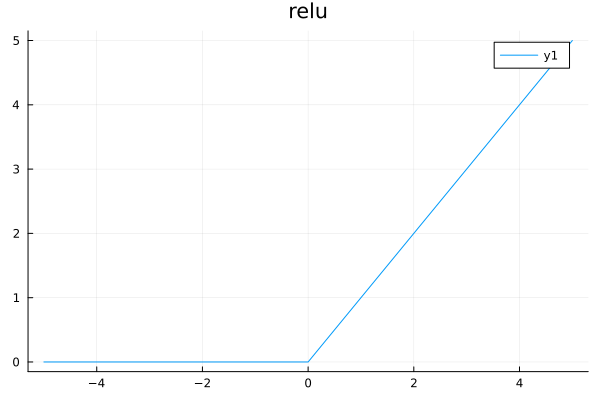

In [85]:
plot(-5:0.1:5,relu,title="relu")

In [86]:
# leakyrelu(x, a=0.01) = max(a*x, x) is like relu but without the hard zero setting in the left side of the zero
@time leakyrelu.( rr );

  0.085405 seconds (133.22 k allocations: 14.596 MiB, 47.78% gc time, 48.74% compilation time)


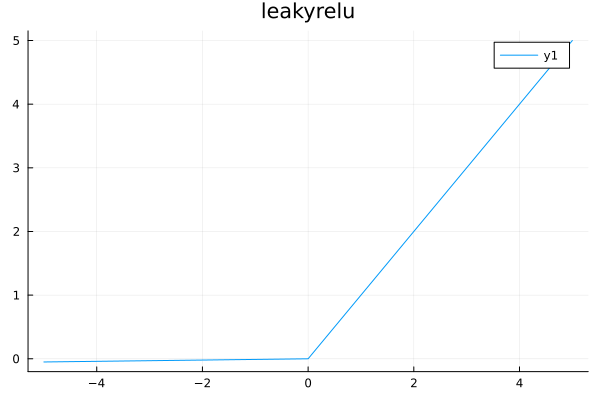

In [87]:
plot(-5:0.1:5,leakyrelu,title="leakyrelu")

### <span style="color:orange">tanh, is likely the first activation function explored, from Kunihito Fukushima in the Cognitron Model</span>

- it spans values from -1 to +1 but as a trigonometric function is more expensive to compute
- Julia reverts to a fast version and a 'hardtanh' stepwise version that is faster

In [88]:
@time tanh_fast.( rr );

  0.047665 seconds (131.37 k allocations: 14.300 MiB, 78.03% compilation time)


In [89]:
# hardtanh(x) = max(-1, min(1, x))
@time hardtanh.( rr );

  0.041530 seconds (128.34 k allocations: 14.415 MiB, 92.95% compilation time)


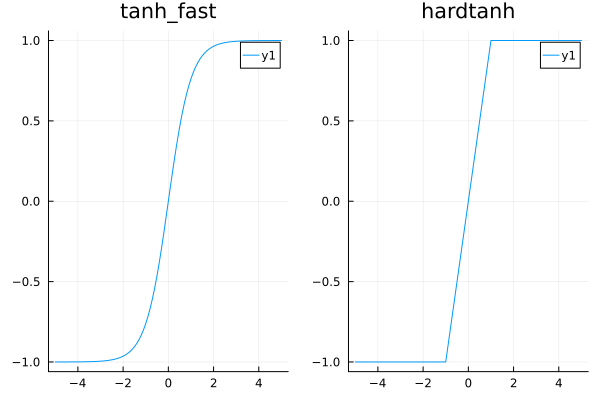

In [90]:
p1 = plot(-5:0.1:5,tanh_fast,title="tanh_fast")
p2 = plot(-5:0.1:5,hardtanh,title="hardtanh")
plot(p1,p2)

### <span style="color:orange">**Softmax**</span>

- After your input passes through multiple layers (transformations) the final layer can be treated in various ways
- If your goal is to do 'regression' that is predict continuous values, you can omit an activation function and omit a final non-linear transformation upon those last neurons
- If your goal is to do some categorical value prediction, like to predict an animal from an image, then each neuron output at the final layer will correspond to one of the selections as your target variables are **one hot encoded** pushing correct answers to be a value 1 on the correct neuron and a 0 on the rest. In the ideal fitted neural network your final outputs will be multiple 0s and a single 1 value for the category position. The neurons here will have activation functions (commonly), and then feed into a softmax.
- Softmax, takes a vector of values, and produces from a set of numbers a normalized vector of values. Normalized, meaning that the original set of number may not add to 1, but the normalized array (set of numbers) after using softmax will sum to 1. 
- The use of softmax is akin to taking the *max* in that there is preference for the values which are larger. You can consider the *max* function as a 'winner takes all* and the softmax amplifies the larger values in relation with the rest but does not completely disregard them. 
- The values of the softmax output can be taken as probabilities 
- The functional operation is akin to the *partition function* used in statistical mechanics

The operation is to take the exponential of each value and then divide that value by the sum of all the exponentiated values
- softmax(x) = exp.(x) ./ sum(exp.(x))

In [91]:
y_hat = [0.3, 0.2, 0.8]
softmax( y_hat )

3-element Vector{Float64}:
 0.28140804404603065
 0.2546285279891599
 0.4639634279648094

### add more elements to see the change, more possible candidates <u>dilute</u> the candidate choice

In [92]:
y_hat = [0.5, 0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.8]
softmax( y_hat )

10-element Vector{Float64}:
 0.12583465263342328
 0.11385990218827859
 0.08434949014611497
 0.08434949014611497
 0.08434949014611497
 0.08434949014611497
 0.08434949014611497
 0.08434949014611497
 0.08434949014611497
 0.16985901415549334

### the absolute difference in value (not only relative) matters in softmax

In [93]:
y_hat = [3, 2, 8]
softmax( y_hat )

3-element Vector{Float64}:
 0.006676412513376451
 0.0024561149044509535
 0.9908674725821726

In [94]:
y_hat = [5, 4, 1, 1, 1, 1, 1, 1, 1, 8]
softmax( y_hat )

10-element Vector{Float64}:
 0.046335712034495005
 0.0170459558495309
 0.0008486681692761851
 0.0008486681692761851
 0.0008486681692761851
 0.0008486681692761851
 0.0008486681692761851
 0.0008486681692761851
 0.0008486681692761851
 0.9306776549310407

### softmax can be applied to a matrix of values along the columns or the rows

- If we apply a NN to multiple inputs (eg, to many images) we received mulitpe final output layer results which independently need the softmax applied to them. These multiple outputs are commonly kept in a matrix (multidimensional array)
- These multiple NN outputs can be kept along the columns of the matrix or on the rows. If each indepdent output is a column of the matrix softmax must be applied to a specific column computing along the rows. analogously for the matrix storing the outputs along each row

In [95]:
y_hat = [1,2,3] #column
display(y_hat)
display( softmax( y_hat , dims=1 ) ) #results as expected as it moves along dim=1 (rows)
display( softmax( y_hat , dims=2 ) ) #results of all 1 since each row has 1 value along the columns (dim=2)

3-element Vector{Int64}:
 1
 2
 3

3-element Vector{Float64}:
 0.09003057317038045
 0.24472847105479764
 0.6652409557748219

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [96]:
y_hat = [1 10 ; 2 20 ; 3 30] # 3x2 matrix
display(y_hat)
display( softmax( y_hat , dims=1 ) ) #along the rows for each column
display( softmax( y_hat , dims=2 ) ) #along the columns for each row

3×2 Matrix{Int64}:
 1  10
 2  20
 3  30

3×2 Matrix{Float64}:
 0.0900306  2.06106e-9
 0.244728   4.53979e-5
 0.665241   0.999955

3×2 Matrix{Float64}:
 0.000123395  0.999877
 1.523e-8     1.0
 1.87953e-12  1.0

### we use *softmax* as final layer output transformations, and not to activation functions between layers

In [97]:
#right and wrong
rdata = rand( 7 , 1 );

In [98]:
#works
d5 = Chain( Dense( 7=>3 , sigmoid ))
display( d5(rdata) )

3×1 Matrix{Float64}:
 0.5319315110937142
 0.7333117225930167
 0.7676680043390478

In [99]:
#does not work
d6 = Chain( Dense( 7=>3 , softmax ))
display( d6(rdata) )

LoadError: `softmax(x)` called with a number, but it expects an array. Usually this is because a layer like `Dense(3,4,softmax)` is broadcasting it like an activation function; `softmax` needs to be outside the layer.

In [100]:
#works by placing the softmax after the 'activation' which when empty is identity
d7 = Chain( Dense( 7=>3 ) , softmax )
display( d7(rdata) )

3×1 Matrix{Float64}:
 0.2729289739230659
 0.06515829841950736
 0.6619127276574267

In [101]:
#works by placing the softmax after the 'activation'
d7 = Chain( Dense( 7=>3 , hardtanh ) , softmax )
display( d7(rdata) )

3×1 Matrix{Float64}:
 0.302692257465749
 0.38760113309720673
 0.3097066094370442

### <span style="color:orange">DataLoader</span>

- It is convenient to feed data to the **train!** function via the DataLoader. **train!** updates the parameters according to the gradient and optimizer, and the DataLoader takes the dataset and passes in the tuples of data in the (x,y) or (features,target) variable format
- It is similar in concept to how R xgboost uses can package the training data 
- DataLoader can be used to produce 'batches' (mini-batches) of data so that the gradient is not based upon the full 
- The DataLoader can be used in multiple ways and there are different uses in conjunction with the training schemes
- DataLoader(data; [batchsize, buffer, collate, parallel, partial, rng, shuffle])
- Takes as input a single data array, a tuple (or a named tuple) of arrays, *the last dimension in each array is the observation dimension*
- Default batchsize is 1
- can be made to run batches in parallel

### <span style="color:orange">In Flux **features span rows** (not columns)</span>

In [102]:
#check the sizes of the batches
Xtrain = rand(10, 100)
array_loader = Flux.DataLoader(Xtrain, batchsize=20) #just the feature data here being packaged (not including the target although we could)
for mbatch in array_loader #iterate over the batch components
    display( size(mbatch) )
end

(10, 20)

(10, 20)

(10, 20)

(10, 20)

(10, 20)

In [103]:
#check the sizes of the batches
Xtrain = rand(10, 100)
Ytrain = Flux.onehotbatch( rand(["a","b","c"],100) , ["a","b","c"])
array_loader = Flux.DataLoader( (Xtrain, Ytrain), batchsize=20) #just the feature data here being packaged (not including the target although we could)
for mbatch in array_loader #iterate over the batch components
    println( "length(mbatch)=$(length(mbatch)), " )
    println( "size(mbatch[1])=$(size(mbatch[1])), size(mbatch[2])=$(size(mbatch[2]))" )
end

length(mbatch)=2, 
size(mbatch[1])=(10, 20), size(mbatch[2])=(3, 20)
length(mbatch)=2, 
size(mbatch[1])=(10, 20), size(mbatch[2])=(3, 20)
length(mbatch)=2, 
size(mbatch[1])=(10, 20), size(mbatch[2])=(3, 20)
length(mbatch)=2, 
size(mbatch[1])=(10, 20), size(mbatch[2])=(3, 20)
length(mbatch)=2, 
size(mbatch[1])=(10, 20), size(mbatch[2])=(3, 20)


In [104]:
Xtrain = rand(10, 100)
Ytrain = rand(["a","b","c"], 100)
#just like with >R's XGBoost< we can set the data and label and then have the data and label in each batch
train_loader = Flux.DataLoader((data=Xtrain, label=Ytrain), batchsize=5)
for batch in train_loader
    println( size(batch.data) )
    println( size(batch.label) )
end

(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)


In [105]:
Xtrain = rand(10, 100)
Ytrain = rand(["a","b","c"], 100)
train_loader = Flux.DataLoader((data=Xtrain, label=Ytrain), batchsize=5)
#we can 'destructure' the batch of the data and label at the start of the loop
for (Xdata, Ylabel) in train_loader
    println( size(Xdata) )
    println( size(Ylabel) )
end

(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)
(10, 5)
(5,)


In [106]:
Xtrain = rand(10, 100)
Ytrain = rand(["a","b","c"], 100)
train_loader = Flux.DataLoader((data=Xtrain, label=Ytrain), batchsize=5 , shuffle=true) #allowing a 'shuffle'
#we can 'destructure' the batch of the data and label at the start of the loop
#we perform multiple passes via epochs for the training scheme
for epoch in 1:5
    ii = 1
    for (Xdata, Ylabel) in train_loader
        @assert size(Xdata) == (10, 5)
        @assert size(Ylabel) == (5,)
        print("ii=$(ii), ")
        ii += 1
    end
    println("epoch num: $(epoch)")
end

ii=1, ii=2, ii=3, ii=4, ii=5, ii=6, ii=7, ii=8, ii=9, ii=10, ii=11, ii=12, ii=13, ii=14, ii=15, ii=16, ii=17, ii=18, ii=19, ii=20, epoch num: 1
ii=1, ii=2, ii=3, ii=4, ii=5, ii=6, ii=7, ii=8, ii=9, ii=10, ii=11, ii=12, ii=13, ii=14, ii=15, ii=16, ii=17, ii=18, ii=19, ii=20, epoch num: 2
ii=1, ii=2, ii=3, ii=4, ii=5, ii=6, ii=7, ii=8, ii=9, ii=10, ii=11, ii=12, ii=13, ii=14, ii=15, ii=16, ii=17, ii=18, ii=19, ii=20, epoch num: 3
ii=1, ii=2, ii=3, ii=4, ii=5, ii=6, ii=7, ii=8, ii=9, ii=10, ii=11, ii=12, ii=13, ii=14, ii=15, ii=16, ii=17, ii=18, ii=19, ii=20, epoch num: 4
ii=1, ii=2, ii=3, ii=4, ii=5, ii=6, ii=7, ii=8, ii=9, ii=10, ii=11, ii=12, ii=13, ii=14, ii=15, ii=16, ii=17, ii=18, ii=19, ii=20, epoch num: 5


In [107]:
# we can change the names of the variables for the feature and target data in both places
Xtrain = rand(10, 100);
Ytrain = rand(["a","b","c"], 100);
train_loader = Flux.DataLoader((xdata=Xtrain, ydata=Ytrain), batchsize=5 , shuffle=true);
for epoch in 1:5
    for (x, y) in train_loader
        @assert size(x) == (10, 5)
        @assert size(y) == (5,)
    end
    println("epoch num: $(epoch)")
end

epoch num: 1
epoch num: 2
epoch num: 3
epoch num: 4
epoch num: 5


### <span style="color:orange">**Encoding**, 1-Hot</span>

- Encoding data is important when we have categorical data. This can be in the features or the target data as well. That is we may have features such as a variable for a type of animal (eg cat/dog/bird) which is represented in **1-Hot Encoding**, eg. $cat \rightarrow [1,0,0], dog\rightarrow [0,1,0], bird \rightarrow [0,0,1]$. That is a single 1 and the rest are zeros and the length of the vector is as long as the number of categorical options. The output target value can also be categorical which is 1-Hot encoded. 
- If we have input data that has 2 continuous features and 2 categorical features where the categorical features can take on 2 discrete values for the first case and 3 different discrete values for the second categorical feature; then the full input vector will have $2+2+3 = 7$ dimensions (input neurons) similarly for the output which if it is to predict a single output class label of 4 different possible labels, there will be 4 output neurons producing values which we take the softmax of, and then compare that to the ground truth data that is 1-hot encoded.
- The difference to dummy variables is that dummy variables are commonly placed in K-1 encoding. 
- Stored in memory efficient format (similar to sparse datastructures)
- We can **index** the results to get a 1 or 0 (or true and false) on each position

In [108]:
# it is in a separate package incase you want to use it outside of flux as well
using OneHotArrays

In [109]:
categories1 = ["apple","beetroot","carrot"]
result1 = onehot("apple", categories1)
result1

3-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅
 ⋅

In [110]:
typeof(result1)

OneHotVector{UInt32, 3} (alias for OneHotArray{UInt32, 3, 0, 1, UInt32})

In [111]:
result2 = onehot("beetroot", categories1)
result2

3-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1
 ⋅

In [112]:
[result2[ii] for ii in 1:length(result2)]

3-element Vector{Bool}:
 0
 1
 0

In [113]:
display(result2[1])
display(result2[2])

false

true

In [114]:
# if it not part of the set
result3 = onehot("beetroot!!!", categories1)
result3

LoadError: Value beetroot!!! is not in labels

In [115]:
# provide a 'default' value for elements not in the set
result4 = onehot("beetroot!!!", categories1,"carrot")
result4

3-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1

In [116]:
# can use numbers as category labels
categories2 = [11,22,33]
result2 = onehot(33, categories2)
result2

3-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1

In [117]:
# we can use 'symbols'
categoriesSymbols = [:sunny,:dark,:raining]
resultSymbols = onehot(:raining, categoriesSymbols)
resultSymbols

3-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1

### <span style="color:orange">One Hot Batch, **onehotbatch**</span>

- We typically have a vector of cateogory labels (prediction categories) and then want the one hot from that 'batch' since we run a mini-batch and get predictions and need the set of one hot encoded vectors and it is good to have them in a matrix

In [118]:
categories3 = ["bird","cat","dog"]
# some hypothetical testing target data
testY = ["cat","dog","bird","bird","dog","cat","cat"]
results3 = onehotbatch(testY,categories3)

3×7 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1  1  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  1  ⋅  ⋅  1  ⋅  ⋅

### <span style="color:orange">One Cold, **onecold**</span>

- This terminology is coined by the Julia developers, as being the opposite of the One Hot, the inverse in a way
- It allows us to supply a one hot encoded vector, or a probability distribution, or Boolean vector to get back the label or symbol 
- This is useful when you want to get the accuracy of categorical predictions in terms of equality

In [119]:
categories3 = ["bird","cat","dog"]
y_hat1 = [0,1,0]
display( onecold(y_hat1, categories3) )
y_hat2 = [0.2, 0.6, 0.2] #plausible softmax output
display( onecold(y_hat2, categories3) )
y_hat3 = [false, true, false]
display( onecold(y_hat3, categories3) )

# go from label to 1-hot and then back to label via 1-cold to give the original
y_hat4 = "cat"
onehot4 = onehot(y_hat4, categories3)
display( onecold(onehot4, categories3) )

"cat"

"cat"

"cat"

"cat"

In [120]:
# get back the labels from the onehotbatch encoding to be the original data
categories3 = ["bird","cat","dog"]
# some hypothetical testing target data
testY = ["cat","dog","bird","bird","dog","cat","cat"]
results3 = onehotbatch(testY,categories3)
display(results3)
results3OneCold = onecold( results3, categories3 )

3×7 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1  1  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  1  ⋅  ⋅  1  ⋅  ⋅

7-element Vector{String}:
 "cat"
 "dog"
 "bird"
 "bird"
 "dog"
 "cat"
 "cat"

### <span style="color:orange">Training models</span>

We saw some examples on training the parameters of a model and now let's look at more ways. Overall approach involves:

- Providing an **Objective Function**. This tells the training scheme how well the model is doing for a set of parameter values. Training can then obtain the gradient of the objective function for the parameters at those values. The objective function is commonly taken to be the **Loss function** as the loss function assesses how the features and the target values do no match according to the defined criteria. Training uses the gradient of the loss function (in respect to the parameters) to know the direction for which the loss value can decrease according to the parameter values. 
- The parameters must be *trainable*
- The data passed can be a single data point, or a collection of data points (mini batch)
- An optimiser will change the parameters according to the gradient, and the gradient gets it direction according to the Objective Function (Loss Function)
- Training is often an **iterative** process that is data->loss function->gradient->optimization of parameters

In [121]:
# train!(loss, pars::Params, data, opt::AbstractOptimiser; [cb])
#future versions of FluxML may change this function call

In [126]:
m1b = Chain( Dense(3 => 2, sigmoid) , Dense(2 => 1) )
#test the data transformation
display( m1b(rand(3)) )
display( m1b([1,2,3]) )
function loss1b( x , y ) #provide the model as an input argument to use the 'train!' function
    println("x = $(x), y = $(y)")
    y_hat = m1b(x)
    println("y_hat = $(y_hat)")
    abs.( y .- y_hat )[1]
end
opt = Flux.setup(Adam(0.5), m1b)

1-element Vector{Float64}:
 -1.454660256016421

1-element Vector{Float32}:
 -1.4428736

(layers = ((weight = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0], Float32[0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0], Float32[0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0], Float32[0.0], (0.9, 0.999))), σ = ())),)

In [127]:
x = [1,2,3]
y = 100 #target
println( "pre-train loss = $(loss1b(x,y))" )
Flux.train!( loss1b , m1b , [(x,y)] , opt ) #this function feeds the model to the loss function so it must take a model as a parameter
println( "post-train loss = $(loss1b(x,y))" )

x = [1, 2, 3], y = 100
y_hat = Float32[-1.4428736]
pre-train loss = 101.44287
x = [1, 2, 3], y = 100
y_hat = Float32[-1.4428736]
x = [1, 2, 3], y = 100
y_hat = Float32[0.3208555]
post-train loss = 99.679146


In [128]:
#let us continue the training
data = [(x,y)]
Flux.train!( loss1b , m1b , data , opt ) 
println("train loss = $(loss1b(x,y))")

x = [1, 2, 3], y = 100
y_hat = Float32[0.3208555]
x = [1, 2, 3], y = 100
y_hat = Float32[0.997559]
train loss = 99.00244


In [129]:
#this can be repetitive so let us just place many repeated data points in the dataset
data = [ (x,y), (x,y), (x,y), (x,y), (x,y), (x,y) ]
Flux.train!( loss1b , m1b , data , opt )
println("train loss = $(loss1b(x,y))")

x = [1, 2, 3], y = 100
y_hat = Float32[0.997559]
x = [1, 2, 3], y = 100
y_hat = Float32[1.5001591]
x = [1, 2, 3], y = 100
y_hat = Float32[2.0000572]
x = [1, 2, 3], y = 100
y_hat = Float32[2.5000167]
x = [1, 2, 3], y = 100
y_hat = Float32[3.0000055]
x = [1, 2, 3], y = 100
y_hat = Float32[3.5000021]
x = [1, 2, 3], y = 100
y_hat = Float32[4.000001]
train loss = 96.0


In [130]:
#has a convenient function called ncycle as we will apply
using IterTools

In [131]:
data = ncycle([(x, y)], 20)
display( length(data) )

20

In [132]:
Flux.train!( loss1b , m1b , data , opt )
println("train loss = $(loss1b(x,y))")

x = [1, 2, 3], y = 100
y_hat = Float32[4.000001]
x = [1, 2, 3], y = 100
y_hat = Float32[4.5000005]
x = [1, 2, 3], y = 100
y_hat = Float32[5.0]
x = [1, 2, 3], y = 100
y_hat = Float32[5.5]
x = [1, 2, 3], y = 100
y_hat = Float32[6.0]
x = [1, 2, 3], y = 100
y_hat = Float32[6.5]
x = [1, 2, 3], y = 100
y_hat = Float32[7.0]
x = [1, 2, 3], y = 100
y_hat = Float32[7.5]
x = [1, 2, 3], y = 100
y_hat = Float32[8.0]
x = [1, 2, 3], y = 100
y_hat = Float32[8.5]
x = [1, 2, 3], y = 100
y_hat = Float32[9.0]
x = [1, 2, 3], y = 100
y_hat = Float32[9.5]
x = [1, 2, 3], y = 100
y_hat = Float32[10.0]
x = [1, 2, 3], y = 100
y_hat = Float32[10.5]
x = [1, 2, 3], y = 100
y_hat = Float32[11.0]
x = [1, 2, 3], y = 100
y_hat = Float32[11.5]
x = [1, 2, 3], y = 100
y_hat = Float32[12.0]
x = [1, 2, 3], y = 100
y_hat = Float32[12.5]
x = [1, 2, 3], y = 100
y_hat = Float32[13.0]
x = [1, 2, 3], y = 100
y_hat = Float32[13.5]
x = [1, 2, 3], y = 100
y_hat = Float32[14.0]
train loss = 86.0


In [133]:
#change the optimizer to make the steps 'larger' needing less steps but more 'coarse'
opt = Flux.setup(Adam(2), m1b)
Flux.train!( loss1b , m1b , data , opt )
println("train loss = $(loss1b(x,y))")

x = [1, 2, 3], y = 100
y_hat = Float32[14.0]
x = [1, 2, 3], y = 100
y_hat = Float32[16.0]
x = [1, 2, 3], y = 100
y_hat = Float32[18.000261]
x = [1, 2, 3], y = 100
y_hat = Float32[21.700321]
x = [1, 2, 3], y = 100
y_hat = Float32[27.282667]
x = [1, 2, 3], y = 100
y_hat = Float32[30.668058]
x = [1, 2, 3], y = 100
y_hat = Float32[34.25228]
x = [1, 2, 3], y = 100
y_hat = Float32[37.965797]
x = [1, 2, 3], y = 100
y_hat = Float32[41.768456]
x = [1, 2, 3], y = 100
y_hat = Float32[45.635666]
x = [1, 2, 3], y = 100
y_hat = Float32[49.551273]
x = [1, 2, 3], y = 100
y_hat = Float32[53.50408]
x = [1, 2, 3], y = 100
y_hat = Float32[57.486015]
x = [1, 2, 3], y = 100
y_hat = Float32[61.491066]
x = [1, 2, 3], y = 100
y_hat = Float32[65.514656]
x = [1, 2, 3], y = 100
y_hat = Float32[69.55321]
x = [1, 2, 3], y = 100
y_hat = Float32[73.60389]
x = [1, 2, 3], y = 100
y_hat = Float32[77.66444]
x = [1, 2, 3], y = 100
y_hat = Float32[81.733]
x = [1, 2, 3], y = 100
y_hat = Float32[85.80807]
x = [1, 2, 3], y = 

In [134]:
m1b( x ) #closish

1-element Vector{Float32}:
 89.88838

In [135]:
#we can run a similar model again but with a more custom loop
#reset with a new model, params optimizer etc
m1c = Chain( Dense(3 => 2, sigmoid) , Dense(2 => 1) )
function loss1c(model, x, y) #passing the model for train!
    y_hat = model(x)
    abs.( y .- y_hat )[1]
end
opt = Flux.setup(Adam(0.5), m1c)

(layers = ((weight = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 0.0; 0.0 0.0 0.0], Float32[0.0 0.0 0.0; 0.0 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0], Float32[0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0], Float32[0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.5, (0.9, 0.999), 1.0e-8), (Float32[0.0], Float32[0.0], (0.9, 0.999))), σ = ())),)

In [136]:
x = [10,20,30]
y = 100 #target
data = ncycle([(x, y)], 2000) #will produce 2000 iterations effectively

IterTools.NCycle{Vector{Tuple{Vector{Int64}, Int64}}}([([10, 20, 30], 100)], 2000)

In [137]:
display(length(data))

2000

In [138]:
#iterators (not just in Julia) have their own methods of being accessed
nth(data,1)

([10, 20, 30], 100)

In [139]:
nth(data,8)

([10, 20, 30], 100)

In [140]:
#we can use iterators in a loop
ii = 1
for data_tmp in data
    if(ii > 3) break end #just do a few
    ii += 1
    display( data_tmp )
    display( data_tmp[1] )
    display( data_tmp[2] )
end

([10, 20, 30], 100)

3-element Vector{Int64}:
 10
 20
 30

100

([10, 20, 30], 100)

3-element Vector{Int64}:
 10
 20
 30

100

([10, 20, 30], 100)

3-element Vector{Int64}:
 10
 20
 30

100

In [141]:
#iterate our training data
#the main difference from before is that the gradient is not extracted explicitly
losses = []
for data_tmp in data
    
    Flux.train!( loss1c , m1c , [data_tmp] , opt )
    push!(losses, loss1c(m1c, data_tmp...) )
    
end
m1c( [1,2,3] )

1-element Vector{Float32}:
 98.72596

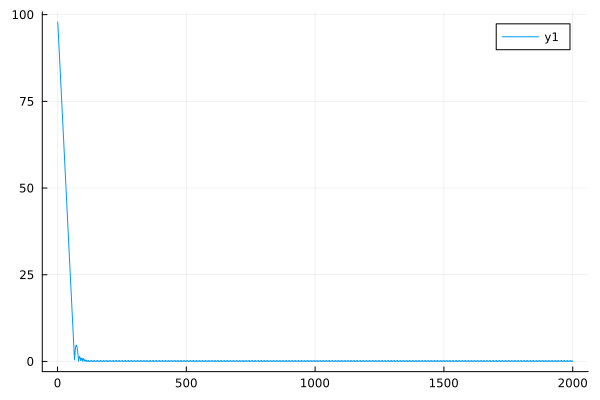

In [142]:
plot(losses)

In [143]:
#iterate our training with early exit
m1c = Chain( Dense(3 => 2, sigmoid) , Dense(2 => 1) )
data = ncycle([(x, y)], 2000)
losses = []
for data_tmp in data
    
    Flux.train!( loss1c , m1c , [data_tmp] , opt )
    push!(losses, loss1c(m1c, data_tmp...) )
    if(losses[end] < 1) break end
end

In [144]:
length(losses)

76

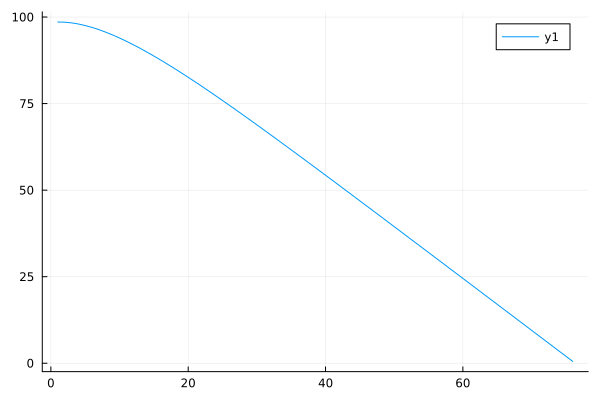

In [145]:
plot(losses)

In [146]:
#test it out
m1c([10,20,30])

1-element Vector{Float32}:
 99.48459

In [147]:
#test it out on different data than the inputs
m1c([1,2,3])

1-element Vector{Float32}:
 99.48459

In [148]:
#let's make the training data to be more than fitting a single point, make it 3 points to fit to the same target
data = ncycle([([1,2,3], 10),([10,20,30], 100),([100,200,300], 200)], 10_000)
m1c = Chain( Dense(3 => 2, sigmoid) , Dense(2 => 1) )
losses = []
for data_tmp in data
    
    Flux.train!( loss1c , m1c , [data_tmp] , opt )
    push!(losses, loss1c(m1c, data_tmp...) )
    if(losses[end] < 1) break end
end

In [149]:
#test it out
m1c([100,200,300])

1-element Vector{Float32}:
 99.16383

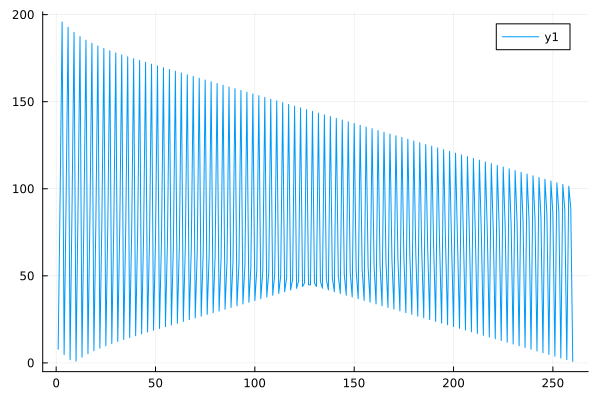

In [150]:
plot(losses)

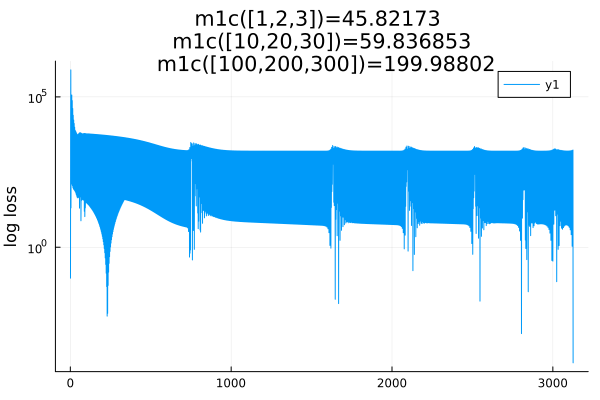

In [151]:
#let's change the model, make it more complex
data = ncycle([([1,2,3], 10),([10,20,30], 100),([100,200,300], 200)], 100_000)

m1c = Chain(Dense(3=>10),Dense(10=>5),Dense(5=>2),Dense(2=>1)) #Chain( Dense(3 => 5) , Dense(5 => 2) , Dense(2 => 1) )

opt = Flux.setup(Adam(0.1), m1c)
loss_m1c( model , x , y ) = Flux.mse( model(x) , y )
losses = []
for data_tmp in data

    Flux.train!( loss_m1c , m1c , [data_tmp] , opt )

    push!(losses, Flux.mse(m1c(data_tmp[1]),data_tmp[2]) )
    if(losses[end] < 0.001) break end
end
plot(losses, yscale=:log10 , ylabel="log loss" ,  title="m1c([1,2,3])=$(m1c([1,2,3])[1]) \n m1c([10,20,30])=$(m1c([10,20,30])[1]) \n m1c([100,200,300])=$(m1c([100,200,300])[1])")

In [152]:
#test it out
m1c([100,200,300])

1-element Vector{Float32}:
 199.98802

In [153]:
#test it out
m1c([10,20,30])

1-element Vector{Float32}:
 59.836853

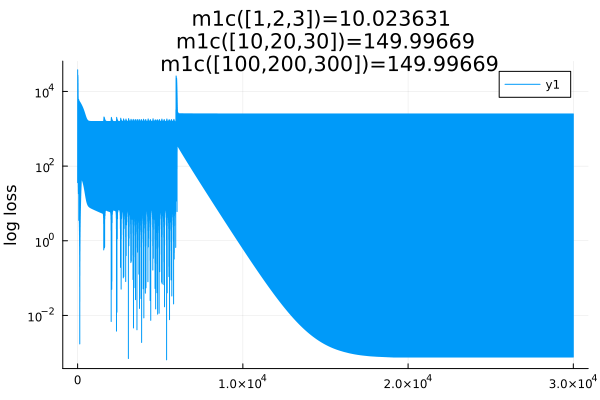

In [154]:
#let's make the model even more complex
data = ncycle([([1,2,3], 10),([10,20,30], 100),([100,200,300], 200)], 10_000)
m1c = Chain( Dense(3 => 10, relu) , Dense(10 => 5, relu) , Dense(5 => 1) )

losses = []
opt = Flux.setup(Adam(0.1), m1c)
loss_m1c( model , x , y ) = Flux.mse( model(x) , y )

for data_tmp in data
    
    Flux.train!( loss_m1c , m1c , [data_tmp] , opt )
    push!(losses, Flux.mse(m1c(data_tmp[1]),data_tmp[2]) )
    
end
plot(losses, yscale=:log10 , ylabel="log loss" ,  title="m1c([1,2,3])=$(m1c([1,2,3])[1]) \n m1c([10,20,30])=$(m1c([10,20,30])[1]) \n m1c([100,200,300])=$(m1c([100,200,300])[1])")

In [155]:
#test it out
m1c([100,200,300])

1-element Vector{Float32}:
 149.99669

In [156]:
#test it out
m1c([10,20,30])

1-element Vector{Float32}:
 149.99669

In [157]:
#test it out
m1c([1,2,3])

1-element Vector{Float32}:
 10.023631

In [158]:
#the more complex model looks better

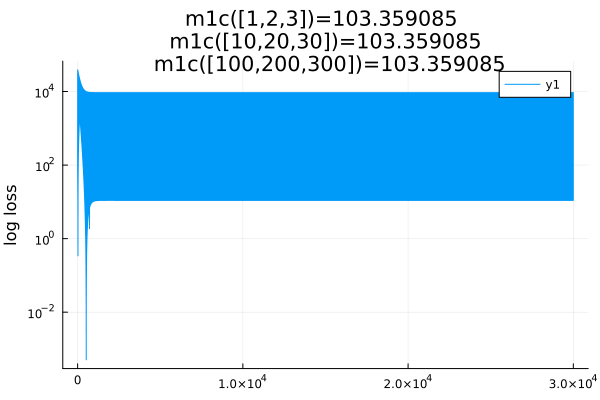

In [159]:
#let's make the model but with different activation functions
data = ncycle([([1,2,3], 10),([10,20,30], 100),([100,200,300], 200)], 10_000)
m1c = Chain( Dense(3 => 10, tanh) , Dense(10 => 5, sigmoid) , Dense(5 => 1) )

opt = Flux.setup(Adam(0.1), m1c)
loss_m1c( model , x , y ) = Flux.mse( model(x) , y )
losses = []
for data_tmp in data
    
    Flux.train!( loss_m1c , m1c , [data_tmp] , opt )
    push!(losses, Flux.mse(m1c(data_tmp[1]),data_tmp[2]) )
    
end
plot(losses, yscale=:log10 , ylabel="log loss" ,  title="m1c([1,2,3])=$(m1c([1,2,3])[1]) \n m1c([10,20,30])=$(m1c([10,20,30])[1]) \n m1c([100,200,300])=$(m1c([100,200,300])[1])")

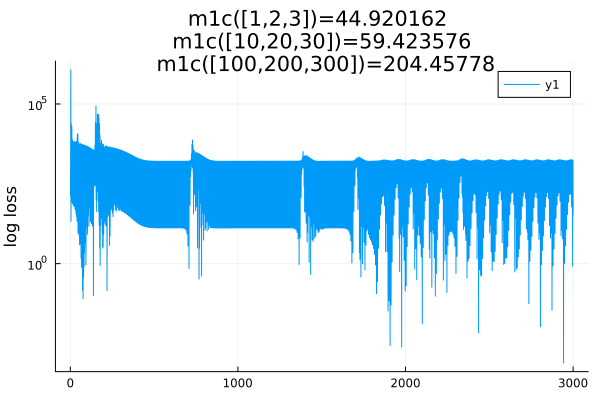

In [160]:
#let's use the update! function instead of the train! function with explicit gradients used
data = ncycle([([1,2,3], 10),([10,20,30], 100),([100,200,300], 200)], 1_000)
m1c = Chain( Dense(3 => 20) , Dense(20 => 20) , Dense(20 => 10) , Dense(10 => 1) )

opt = Flux.setup(Adam(0.05), m1c)

losses = []
for data_tmp in data
    
    #get the gradients
    loss, grads = Flux.withgradient(m1c) do model
        y_hat = model(data_tmp[1])
        Flux.mse(y_hat,data_tmp[2])
    end
    Flux.update!(opt, m1c, grads[1])
    push!(losses,loss) #don't put this in the above block where the gradient is computed
    
end

plot(losses, yscale=:log10 , ylabel="log loss" ,  title="m1c([1,2,3])=$(m1c([1,2,3])[1]) \n m1c([10,20,30])=$(m1c([10,20,30])[1]) \n m1c([100,200,300])=$(m1c([100,200,300])[1])")

### <span style="color:orange">Different ways of loading the data</span>

- There are different ways to load the data, till now the data was loaded by using a set of tuples.
- It is common to have the features and target data be in separate datastructures
- Features and targets can be brought together via the zip function and the DataLoader function

### <span style="color:orange">Let us try data that is a unimodal shape</span>

In [161]:
#100 data points
function fn3(x) 
    1*exp( -(sum(x)-5)^2 ) #similar to a bell curve
end
x = rand(10,300) #features
y = [ fn3(xTmp) for xTmp in eachcol(x) ]; #iterate over columns
data = Flux.DataLoader((x, y), batchsize=20, shuffle=true) #in batches of 20 points each time

MLUtils.DataLoader{Tuple{Matrix{Float64}, Vector{Float64}}, Random._GLOBAL_RNG, Val{nothing}}(([0.2192570695582281 0.17113900520801328 … 0.8911324610416125 0.2397842806705398; 0.20263373394444162 0.9337010662634139 … 0.7436827811935173 0.8824938407695975; … ; 0.6574381612432341 0.5233033801783912 … 0.1306753144584697 0.14240971493131427; 0.8952202954373656 0.9186814256439737 … 0.4933461787982717 0.17890870206514065], [0.38704043308576874, 0.4575379878649245, 0.9984934424463453, 0.8423519874508626, 0.04638290565482687, 0.9917664679858025, 0.23304846323897185, 0.8551268185771536, 0.08189751106834027, 0.8837408083675785  …  0.28362197571064846, 0.03354807840759295, 0.29528209301826785, 0.4312021992998062, 0.9950311379117822, 0.9791660399500263, 0.24339017328908552, 0.9002032815335269, 0.997791211649149, 0.9995172906032934]), 20, false, true, true, false, Val{nothing}(), Random._GLOBAL_RNG())

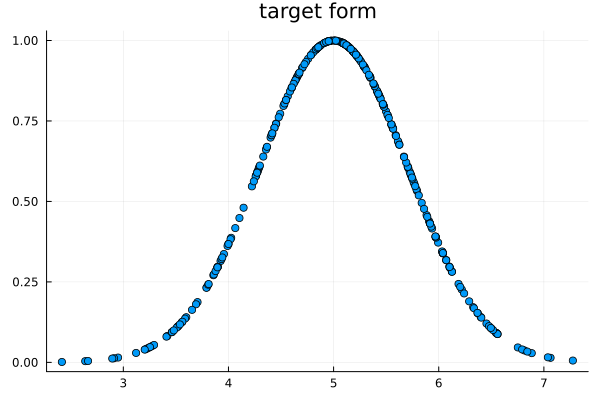

In [162]:
xs = [ sum(xx) for xx in eachcol(x) ]
p0 = scatter( xs , y , legend=false , title="target form" )
display(p0)

(300,)


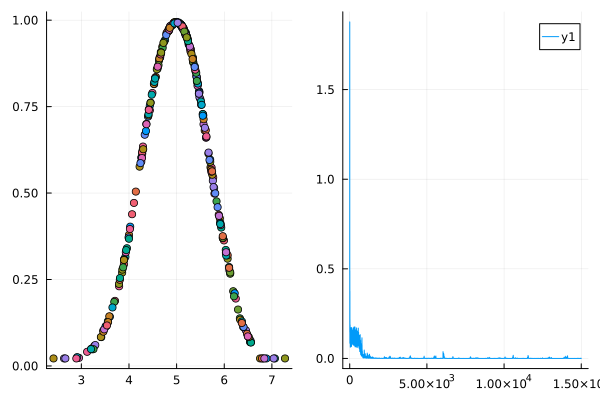

In [163]:
m1c = Chain(Dense(10=>50,relu),Dense(50=>20,sigmoid), Dense(20=>10,relu),Dense(10=>1) )

opt = Flux.setup(Adam(0.05), m1c)
losses = []
for e in 1:1000
    for (x,y) in data
        
        loss, grads = Flux.withgradient(m1c) do model            
            y_hat = vec(model(x))
            Flux.mse(y_hat,y)
        end
        Flux.update!(opt, m1c, grads[1])
        push!(losses,loss) #don't put this in the above block where the gradient is computed
        
    end
end
#look at the predictive form
yPred = [ m1c(xTmp) for xTmp in eachcol(x) ]; #iterate over columns
println( size(yPred) )
p1 = scatter( sum(x, dims=1) , yPred , legend=false )
p2 = plot(losses)
plot(p1,p2)

(300,)


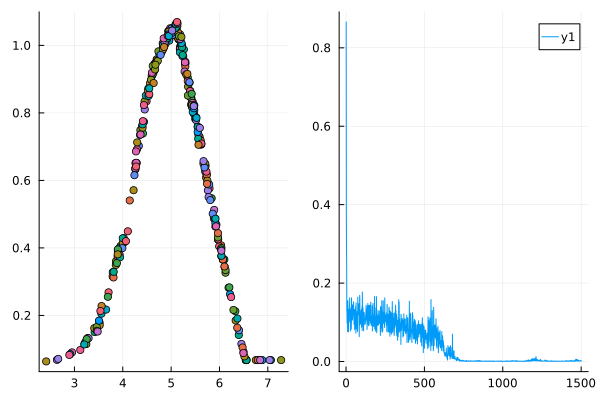

In [164]:
m1c = Chain(Dense(10=>2,tanh),Dense(2=>10,relu),Dense(10=>1) )

losses = []

opt = Flux.setup(Adam(0.05), m1c)

for e in 1:100
    for (x,y) in data
        
        loss, grads = Flux.withgradient(m1c) do model            
            y_hat = vec(model(x))
            Flux.mse(y_hat,y)
        end
        Flux.update!(opt, m1c, grads[1])
        push!(losses,loss) #don't put this in the above block where the gradient is computed
        
    end
end
yPred = [ m1c(xTmp) for xTmp in eachcol(x) ]; #iterate over columns
println( size(yPred) )
p1 = scatter( sum(x, dims=1) , yPred , legend=false )
p2 = plot(losses)
plot(p1,p2)

### <span style="color:orange">Loss Functions</span>

- You can write your own loss functions as done before or use functions that come with Flux, or from some other repository
- As with activation functions there are many possible choices and you have to explore which is going to be best but normally a small subset will be often suffice

In [165]:
# mean absolute error: agg(abs.(ŷ .- y))
#function 'agg' is default mean
y = [1,3,6,12,100]
y_hat = [1,4,6.5,15,200]

losses1 = Flux.mae(y_hat, y)
display(losses1)
println("-------")
losses2 = Flux.mae(y_hat, y, agg=sum) #get the sum of all those errors
display(losses2)

20.9

-------


104.5

In [166]:
# mean squared error (MSE): agg((ŷ .- y) .^ 2)
y = [1,3,6,12,100]
y_hat = [1,4,6.5,15,200]

losses1 = Flux.mse(y_hat, y)
display(losses1)
println("-------")

losses2 = Flux.mse(y_hat, y, agg=sum) #get the sum of all those errors
display(losses2)

2002.05

-------


10010.25

In [167]:
# mean squared 'logarithmic' errors (MSLE): agg((log.(ŷ .+ ϵ) .- log.(y .+ ϵ)) .^ 2)
# so that extreme deviations do not contaminate the results as much (attenuation)
y = [1,3,6,12,100]
y_hat = [1,4,6.5,15,200]

losses1 = Flux.msle(y_hat, y)
display(losses1)
println("-------")

losses2 = Flux.msle(y_hat, y, agg=sum) #get the sum of all those errors
display(losses2)

0.12388277365463632

-------


0.6194138682731816

In [168]:
# mean squared 'logarithmic' errors (MSLE): agg((log.(ŷ .+ ϵ) .- log.(y .+ ϵ)) .^ 2)
# so that extreme deviations do not contaminate the results as much (attenuation)
y = [1,3,6,12,100]
y_hat = [1,4,6.5,15,200]

losses1 = Flux.msle(y_hat, y)
display(losses1)
println("-------")

losses2 = Flux.msle(y_hat, y, agg=sum) #get the sum of all those errors
display(losses2)

0.12388277365463632

-------


0.6194138682731816

In [169]:
#(categorical targets) crossentropy produces the cross entropy between the distributions along labels
#for multiclass classification, y is often a onehot vector target (still a distribution) and y_hat distribution
#often y_hat comes from output of a softmax
#agg(-sum(y .* log.(ŷ .+ ϵ); dims))
y = onehot(3, 1:4)
display(y)
y_hat = [0, 0, 1, 0]
display( Flux.crossentropy(y, y_hat) )
println("-------")

y_hat = [0.2, 0.1, 0.6, 0.1]
display( Flux.crossentropy(y, y_hat) )
println("-------")

y = onehotbatch([2,1,3], 1:4)
display( y )
y_hat = softmax(rand(4,3))
display( y_hat )
display( Flux.crossentropy(y, y_hat) )
println("-------")

4-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1
 ⋅

-2.2204460492503128e-16

-------


14.417461355646862

-------


4×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅
 1  ⋅  ⋅
 ⋅  ⋅  1
 ⋅  ⋅  ⋅

4×3 Matrix{Float64}:
 0.313316  0.18648   0.290049
 0.250593  0.195348  0.287936
 0.191073  0.205091  0.136834
 0.245018  0.413081  0.285181

29.148423525842066

-------


In [170]:
# logitcrossentropy is the operation of taking the cross entropy of the softmax results with some improvements
# instead of crossentropy(softmax(y_hat),y) using logitcrossentropy
y = onehotbatch([1,3,1,2], 1:4)
y_hat = exp.(rand(4,4) .+ 0.5)
display( Flux.logitcrossentropy(y_hat, y) )
display( Flux.crossentropy(softmax(y_hat), y) )

1.2267402661088127

1.2267402661088118

In [171]:
#(categorical) label_smoothing helps with 'over confidence', with a smoothing factor alpha ('a')
#for binary-class: y .* (1-α) .+ α/2, if a=0 predictions remain the same, a=1 all is 0.5 (uniform)
#for multi-class: y .* (1-α) .+ α / size(y, dims), if a=0 predictions remain the same, a=1 uniform across labels
y = onehot(0, [0,1])
display(y)
y_smooth = Flux.label_smoothing(y, 0.25)
display(y_smooth)
println("-------")

y = onehot(1, [0,1])
display(y)
y_smooth = Flux.label_smoothing(y, 0.75)
display(y_smooth)
println("-------")

y = onehotbatch([1,0,0,1,1], [0,1])
display(y)
y_smooth = Flux.label_smoothing(y, 0.25)
display(y_smooth)


2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

2-element Vector{Float64}:
 0.875
 0.125

-------


2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

2-element Vector{Float64}:
 0.375
 0.625

-------


2×5 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  1  ⋅  ⋅
 1  ⋅  ⋅  1  1

2×5 Matrix{Float64}:
 0.125  0.875  0.875  0.125  0.125
 0.875  0.125  0.125  0.875  0.875

In [172]:
#it is also considered good practice to smooth labels prior ot using crossentropy
#we can reduce the confidence in the target labels
y = onehotbatch([2,1,3], 1:4)
y_smooth = Flux.label_smoothing(y, 0.25)
display( y_smooth )
y_hat = softmax(rand(4,3))
display( y_hat )
display( Flux.crossentropy(y, y_smooth) )

4×3 Matrix{Float64}:
 0.0625  0.8125  0.0625
 0.8125  0.0625  0.0625
 0.0625  0.0625  0.8125
 0.0625  0.0625  0.0625

4×3 Matrix{Float64}:
 0.192557  0.198583  0.19754
 0.30687   0.321086  0.257579
 0.313196  0.268278  0.293781
 0.187376  0.212053  0.251101

6.758185010459466

In [173]:
#kldivergence, Kullback-Leibler divergence between the given probability distributions
#returns zero when the distributions are equal and is non-negative
p1 = [0.3, 0.1, 0.6]
p2 = [0.4, 0.0, 0.6]
display( Flux.kldivergence(p1, p2) )
println("-------")

p1 = [0.3, 0.1, 0.6]
p2 = [0.01, 0.0, 0.99]
display( Flux.kldivergence(p1, p2) )
display( Flux.kldivergence(p2, p1) )
println("-------")

p1 = [0.1 0.1 0.1; 0.3 0.2 0.1; 0.6 0.7 0.8]
display(p1)
p2 = [0.1 0.3 0.8; 0.3 0.3 0.1; 0.6 0.4 0.1]
display(p2)
display( Flux.kldivergence(p1, p2) )
println("-------")

0.1150728289807118

-------


0.46175556121674255

4.094000871363456

-------


3×3 Matrix{Float64}:
 0.1  0.1  0.1
 0.3  0.2  0.1
 0.6  0.7  0.8

3×3 Matrix{Float64}:
 0.1  0.3  0.8
 0.3  0.3  0.1
 0.6  0.4  0.1

0.5609953276781978

-------


In [174]:
#focal_loss is good to use in classification tasks with highly imbalanced classes by downweighting 
#well classified examples and focus on the hard ones
y = onehotbatch(Int.(round.(4 .* rand(4))), 0:4)
display(y)
y_hat = softmax(rand(5,4))
Flux.focal_loss(y_hat,y)

5×4 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1
 1  ⋅  1  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅

0.993333037539857

In [175]:
#siamese_contrastive_loss for siamese networks, robust to imbalance and can change the label set
y_hat = [0.5,0.2,0.3]
Flux.siamese_contrastive_loss(y_hat, 1:3)

0.9266666666666667

In [ ]:
### <span style="color:orange"></span>

In [ ]:
### <span style="color:orange"></span>

In [ ]:
### <span style="color:orange"></span>

In [ ]:
### <span style="color:orange"></span>

In [20]:
### <span style="color:orange"></span>

In [21]:
### <span style="color:orange"></span>

In [22]:
### <span style="color:orange"></span>

In [23]:
### <span style="color:orange"></span>

In [24]:
### <span style="color:orange"></span>

In [25]:
### <span style="color:orange"></span>

In [26]:
### <span style="color:orange"></span>

In [27]:
### <span style="color:orange"></span>

In [ ]:
### <span style="color:orange"></span>